In [ ]:
import random
import sisl
import torch
import torch.optim as optim
import numpy as np
import yaml

from e3nn import o3
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch_geometric.loader import DataLoader
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.bindings.e3nn import E3nnGraph2Mat
from graph2mat.models import MatrixMACE
from graph2mat.bindings.torch import TorchBasisMatrixDataset
from graph2mat import (
    PointBasis,
    BasisTableWithEdges,
    BasisConfiguration,
    MatrixDataProcessor,
)

def load_config(path="../config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)
    
def flatten(c):
    return [a for b in c for a in b]

/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.

In [4]:
def get_basis_from_structures_paths(paths, verbose=False, num_unique_z=None):
    """_summary_

    Args:
        paths (list[str]): _description_
        verbose (bool, optional): _description_. Defaults to False.
        num_unique_z (int, optional): If known, input the total number of different atom types here for faster performance.

    Returns:
        list[PointBasis]: _description_
    """
    if verbose:
        print("="*60)
        print("Basis computation.")
        print(f"Number of structures to look on: {len(paths)}")
        print("Looking for unique atoms in each structure...")

    unique_atom_types = []
    unique_atom_types_path_idx = []

    # Look for all atom types in your list of structures
    iterator = tqdm(enumerate(paths)) if verbose else enumerate(paths)
    for i, path in iterator:
        if num_unique_z is not None and len(unique_atom_types) == num_unique_z:
            print("Found enough basis points. Breaking the search...")
            break
        geometry = sisl.get_sile(path / "aiida.fdf").read_geometry()
        for z in geometry.atoms.Z:
            if z not in unique_atom_types:
                unique_atom_types.append(z)
                unique_atom_types_path_idx.append(i)
            if num_unique_z is not None and len(unique_atom_types) == num_unique_z:
                print("Found enough basis points. Breaking the search...")
                break
        # print("n_atoms= ", len(geometry.atoms.Z))

    if verbose:
        print(f"Found the following atomic numbers: {unique_atom_types}")
        print(f"Corresponding path indices: {unique_atom_types_path_idx}")

    # Build the basis
    basis = []
    unique_atom_types_basis = []
    for path_idx in unique_atom_types_path_idx:
        geometry = sisl.get_sile(paths[path_idx] / "aiida.fdf").read_geometry()
        for atom in geometry.atoms:
            if atom.Z not in unique_atom_types_basis:
                basis.append(PointBasis.from_sisl_atom(atom))
                unique_atom_types_basis.append(atom.Z)

    basis.sort(key=lambda x: x.type)
    unique_atom_types_basis.sort()

    if verbose:
        print(f"Basis with {len(basis)} elements built!")
        [print(f"\nBasis for atom {i}.\n\tAtom type: {basis[i].type}\n\tBasis: {basis[i].basis}\n\tBasis convention: {basis[i].basis_convention}\n\tR: {basis[i].R}") for i in range(len(basis))]

    return basis

In [5]:
# === Configuration load ===
directory = Path("../results/hamiltonian") # * Write here the directory where the model is stored
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
filename = "model_epoch_4500.tar"
print(f"Loading model {directory / filename}...")


config = load_config(directory / "config.yaml")

# === List of paths to all structures ===
parent_path = Path('../dataset')
n_atoms_paths = list(parent_path.glob('*/'))
paths = []
for n_atoms_path in n_atoms_paths:
    structure_paths = list(n_atoms_path.glob('*/'))
    paths.append(structure_paths)
paths = flatten(paths)

random.seed(config["dataset"]["seed"])
random.shuffle(paths)



# == Basis creation === 
basis = get_basis_from_structures_paths(paths, verbose=False, num_unique_z=config["dataset"].get("num_unique_z", None))
table = BasisTableWithEdges(basis)



# === Dataset creation ===
processor = MatrixDataProcessor(basis_table=table, symmetric_matrix=True, sub_point_matrix=False)
embeddings_configs = []
for i, path in enumerate(paths):

    # We need to keep track of the training/val splits, so we can't plot more than used for training (at least for training dataset)
    if i==20:
        break
    
    print(f"Processing structure {i+1} of {len(paths)}...")

    # Load the structure config
    file = sisl.get_sile(path / "aiida.fdf")
    file_h = sisl.get_sile(path / "aiida.HSX")
    geometry = file.read_geometry()

    # Load the true hamiltonian
    true_h = file_h.read_hamiltonian()

    embeddings_config = BasisConfiguration.from_matrix(
        matrix = true_h,
        geometry = geometry,
        labels = True,
        metadata={
            "atom_types": torch.from_numpy(geometry.atoms.Z), # Unlike point_types, this is not rescaled.,
            "path": path
        },
    )

    embeddings_configs.append(embeddings_config)

dataset = TorchBasisMatrixDataset(embeddings_configs, data_processor=processor)

# Split and stratify
# n_atoms_list = [dataset[i].num_nodes for i in range(len(dataset))] if config["dataset"]["stratify"] == True else None
n_atoms_list = None
train_dataset, val_dataset = train_test_split(
    dataset, 
    train_size=config["dataset"]["train_split_ratio"],
    stratify=n_atoms_list,
    random_state=None # Dataset already shuffled (paths)
)

Loading model ../results/hamiltonian/model_epoch_4500.tar...
Found enough basis points. Breaking the search...
Found enough basis points. Breaking the search...
Processing structure 1 of 1311...
Processing structure 2 of 1311...
Processing structure 3 of 1311...


/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/minico

Processing structure 4 of 1311...
Processing structure 5 of 1311...
Processing structure 6 of 1311...
Processing structure 7 of 1311...


/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(


Processing structure 8 of 1311...
Processing structure 9 of 1311...
Processing structure 10 of 1311...


/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(


Processing structure 11 of 1311...
Processing structure 12 of 1311...


/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(


Processing structure 13 of 1311...
Processing structure 14 of 1311...
Processing structure 15 of 1311...
Processing structure 16 of 1311...
Processing structure 17 of 1311...


/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(


Processing structure 18 of 1311...
Processing structure 19 of 1311...
Processing structure 20 of 1311...


/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(
/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/graph2mat/core/data/matrices/__init__.py:40: UserWarning: <class 'sisl.physics.Hamiltonian'> is not a known matrix type key, falling back to generic OrbitalMatrix class.
  warn(


In [6]:
Path(dataset[0].metadata["path"])

PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/907c-7487-46bd-8ad3-65b031f7f12b')

In [7]:
import numpy as np

kxs = np.linspace(0,1, num=40)
kys = np.linspace(0,1, num=40)
kzs = np.linspace(0,1, num=40) # * Change the resolution here
k_dir_x = geometry.rcell[:,0]
k_dir_y = geometry.rcell[:,1]
k_dir_z = geometry.rcell[:,2]
k_path_x=np.array([kx*k_dir_x for kx in kxs])
k_path_y=np.array([ky*k_dir_y for ky in kys])
k_path_z=np.array([kz*k_dir_z for kz in kzs])
k_path=np.concatenate([k_path_x, k_path_y, k_path_z])

In [8]:
k_path

array([[0.        , 0.        , 0.        ],
       [0.04475216, 0.        , 0.        ],
       [0.08950431, 0.        , 0.        ],
       [0.13425647, 0.        , 0.        ],
       [0.17900863, 0.        , 0.        ],
       [0.22376078, 0.        , 0.        ],
       [0.26851294, 0.        , 0.        ],
       [0.31326509, 0.        , 0.        ],
       [0.35801725, 0.        , 0.        ],
       [0.40276941, 0.        , 0.        ],
       [0.44752156, 0.        , 0.        ],
       [0.49227372, 0.        , 0.        ],
       [0.53702588, 0.        , 0.        ],
       [0.58177803, 0.        , 0.        ],
       [0.62653019, 0.        , 0.        ],
       [0.67128235, 0.        , 0.        ],
       [0.7160345 , 0.        , 0.        ],
       [0.76078666, 0.        , 0.        ],
       [0.80553882, 0.        , 0.        ],
       [0.85029097, 0.        , 0.        ],
       [0.89504313, 0.        , 0.        ],
       [0.93979528, 0.        , 0.        ],
       [0.

In [9]:
import plotly.graph_objects as go
import numpy as np

def plot_predictions_vs_truths(predictions, truths, series_names=None, 
                               title='True vs Predicted Values', 
                               xaxis_title='True Values', 
                               yaxis_title='Predicted Values', 
                               legend_title='Series',
                               show_diagonal=True, 
                               show_points=True,
                               path=None):
    """
    Plots true values vs predictions for multiple series using Plotly.
    
    Parameters:
    predictions (np.ndarray): 2D array of predicted values (rows: series, columns: points).
    truths (np.ndarray): 2D array of true values (same shape as predictions).
    series_names (list, optional): Names for each series. Defaults to generic names.
    title (str, optional): Plot title.
    xaxis_title (str, optional): X-axis title.
    yaxis_title (str, optional): Y-axis title.
    legend_title (str, optional): Legend title.
    show_diagonal (bool, optional): Whether to show the diagonal line.
    show_points (bool, optional): Whether points are visible by default (False sets to 'legendonly').
    path (str, optional): Path to save the plot as HTML.
    """
    # Validate input shapes
    if predictions.shape != truths.shape:
        raise ValueError("predictions and truths must have the same shape")
    
    n_series = predictions.shape[0]
    
    # Generate default series names if not provided
    if series_names is None:
        series_names = [f'Series {i+1}' for i in range(n_series)]
    elif len(series_names) != n_series:
        raise ValueError("series_names length must match number of series")
    
    # Create traces for each series
    traces = []
    for i in range(n_series):
        trace = go.Scatter(
            x=truths[i],
            y=predictions[i],
            mode='markers',
            name=series_names[i],
            visible=None if show_points else 'legendonly'
        )
        traces.append(trace)
    
    # Create diagonal line trace if enabled
    if show_diagonal:
        all_values = np.concatenate([truths.flatten(), predictions.flatten()])
        min_val, max_val = min(all_values), max(all_values)
        diagonal_trace = go.Scatter(
            x=[min_val, max_val],
            y=[min_val, max_val],
            mode='lines',
            line=dict(dash='dash', color='gray'),
            name='Perfect Prediction'
        )
        traces.append(diagonal_trace)
    
    # Create figure and update layout
    fig = go.Figure(data=traces)
    fig.update_layout(
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        legend_title=legend_title
    )
    
    # Save to HTML if path is provided
    if path:
        fig.write_html(path)
    
    return fig

# Example usage
np.random.seed(42)
# Generate random data: 3 series, 50 points each
truths = np.random.rand(3, 50) * 100
predictions = truths + np.random.randn(3, 50) * 10  # Add noise

# Generate plot
fig = plot_predictions_vs_truths(
    predictions=predictions,
    truths=truths,
    series_names=['Model A', 'Model B', 'Model C'],
    title='Model Predictions vs True Values',
    xaxis_title='Measured Values',
    yaxis_title='Predicted Values',
    legend_title='Models',
    show_diagonal=True,
    show_points=True,
    path=
)
fig

v

SyntaxError: expected argument value expression (681642823.py, line 96)

In [18]:
titles_series = [f"[{"{:.2f}".format(k_point[0]) if k_point[0] != 0 else 0}, {"{:.2f}".format(k_point[1]) if k_point[1] != 0 else 0}, {"{:.2f}".format(k_point[2]) if k_point[2] != 0 else 0}]" for k_point in k_path]
print(titles_series)

['[0, 0, 0]', '[0.04, 0, 0]', '[0.09, 0, 0]', '[0.13, 0, 0]', '[0.18, 0, 0]', '[0.22, 0, 0]', '[0.27, 0, 0]', '[0.31, 0, 0]', '[0.36, 0, 0]', '[0.40, 0, 0]', '[0.45, 0, 0]', '[0.49, 0, 0]', '[0.54, 0, 0]', '[0.58, 0, 0]', '[0.63, 0, 0]', '[0.67, 0, 0]', '[0.72, 0, 0]', '[0.76, 0, 0]', '[0.81, 0, 0]', '[0.85, 0, 0]', '[0.90, 0, 0]', '[0.94, 0, 0]', '[0.98, 0, 0]', '[1.03, 0, 0]', '[1.07, 0, 0]', '[1.12, 0, 0]', '[1.16, 0, 0]', '[1.21, 0, 0]', '[1.25, 0, 0]', '[1.30, 0, 0]', '[1.34, 0, 0]', '[1.39, 0, 0]', '[1.43, 0, 0]', '[1.48, 0, 0]', '[1.52, 0, 0]', '[1.57, 0, 0]', '[1.61, 0, 0]', '[1.66, 0, 0]', '[1.70, 0, 0]', '[1.75, 0, 0]', '[0, 0, 0]', '[0, 0.04, 0]', '[0, 0.09, 0]', '[0, 0.13, 0]', '[0, 0.18, 0]', '[0, 0.22, 0]', '[0, 0.27, 0]', '[0, 0.31, 0]', '[0, 0.36, 0]', '[0, 0.40, 0]', '[0, 0.45, 0]', '[0, 0.49, 0]', '[0, 0.54, 0]', '[0, 0.58, 0]', '[0, 0.63, 0]', '[0, 0.67, 0]', '[0, 0.72, 0]', '[0, 0.76, 0]', '[0, 0.81, 0]', '[0, 0.85, 0]', '[0, 0.90, 0]', '[0, 0.94, 0]', '[0, 0.98, 0]

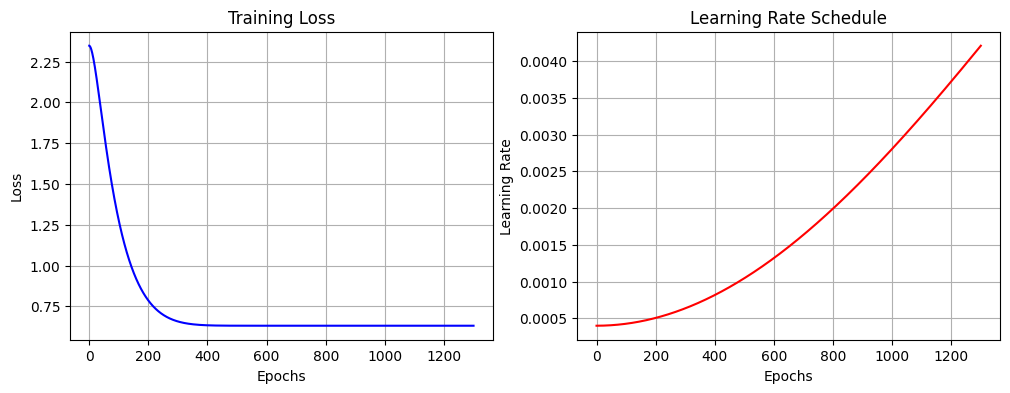

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Generate synthetic data
X = torch.linspace(-1, 1, 100).view(-1, 1)
y = 3 * X + 0.8 * torch.randn(X.size())

# Simple model
model = nn.Sequential(nn.Linear(1, 1))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# CyclicLR scheduler
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=0.001,       # Initial learning rate
    max_lr=0.1,          # Maximum learning rate
    step_size_up=50,     # Steps per half-cycle
    mode='triangular',   # Standard triangular policy
    cycle_momentum=False, # Important for SGD
)

# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=1, epochs=10000)

# Prepare plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.ion()  # Interactive mode

# Training loop
losses = []
lrs = []
epochs = 2000

for epoch in range(epochs):
    # Forward pass
    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # Record learning rate
    current_lr = scheduler.get_last_lr()[0]
    lrs.append(current_lr)
    
    # Update plots every 10 epochs
    if epoch % 10 == 0:
        ax1.clear()
        ax2.clear()
        
        # Loss curve
        ax1.plot(losses, 'b-')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # Learning rate curve
        ax2.plot(lrs, 'r-')
        ax2.set_title('Learning Rate Schedule')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Learning Rate')
        ax2.grid(True)
        
        # Dynamic display
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.1)

plt.ioff()
plt.show()

# Print final parameters
print("Training completed!")
print(f"Final weights: {model[0].weight.data.item():.3f}")
print(f"Final bias: {model[0].bias.data.item():.3f}")

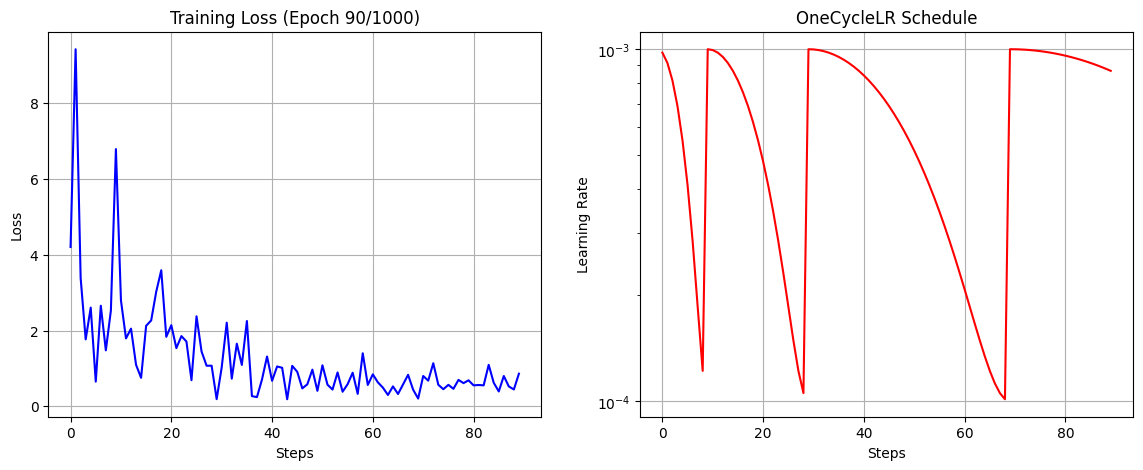

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython import display

# Generate synthetic data
X = torch.randn(1000, 1)  # 1000 samples
y = 3 * X + 0.8 * torch.randn(X.size())

# Create dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Simple model
model = nn.Sequential(nn.Linear(1, 1))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# OneCycleLR parameters
epochs = 1000 # * aaaaaaaaaaaaaaaaaaa
# total_steps = 500 * len(dataloader)  # 10 epochs * batches per epoch
# scheduler = optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=0.1,                     # Upper learning rate boundary
#     # total_steps=total_steps,         # Total number of training steps
#     epochs=epochs*1000,                      # Number of epochs
#     steps_per_epoch=5, # Batches per epoch
#     # # pct_start=0.1,                  # Fraction of steps spent increasing LR
#     # anneal_strategy='linear',        # Annealing strategy
#     # # div_factor=10.0,                # max_lr / initial_lr
#     # final_div_factor=1e100         # initial_lr / min_lr
# )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, cooldown=0, min_lr=0, eps=0)
# scheduler2 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1)
# # scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[2])
# # scheduler = optim.lr_scheduler.ChainedScheduler([scheduler1, scheduler2], optimizer=optimizer)
# scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=0.5, total_iters=20)
# scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.33, total_iters=4)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=0.0, last_epoch=-1)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2, eta_min=1e-4, last_epoch=-1)

# Prepare plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plt.ion()  # Interactive mode

# Training variables
losses = []
lrs = []
step_count = 0

# Training loop
for epoch in range(epochs):
    for batch_x, batch_y in dataloader:
        # Forward pass
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)
        
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update scheduler and record LR
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    lrs.append(current_lr)
    losses.append(loss.item())
    step_count += 1
    
    # Update plots every 20 steps
    if step_count % 1 == 0:
        ax1.clear()
        ax2.clear()
        
        # Loss curve
        ax1.plot(losses, 'b-')
        ax1.set_title(f'Training Loss (Epoch {epoch+1}/{epochs})')
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # Learning rate curve
        ax2.plot(lrs, 'r-')
        ax2.set_title('OneCycleLR Schedule')
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Learning Rate')
        ax2.set_yscale('log')
        ax2.grid(True)
        
        # Dynamic display
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.1)

plt.ioff()
plt.show()

# Print final parameters
print("Training completed!")
print(f"Final weights: {model[0].weight.data.item():.3f}")
print(f"Final bias: {model[0].bias.data.item():.3f}")

In [12]:
len(dataloader)

32